# Text Mining: Course introduction

This course uses [Jupyter notebooks](http://jupyter.org/) for the lab assignments. Notebooks let you write and execute Python code in a web browser, and they make it very easy to mix code and text.

The purpose of this particular notebook is to give you a glimpse of what is to come.

## Load some data

Load a data set of movie reviews.

In [4]:
!npx degit https://github.com/Noufal21/text-mining --force

npx: installed 1 in 1.038s
> destination directory is not empty. Using --force, continuing
> cloned Noufal21/text-mining#master


In [34]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=1cde84e9bb2778da9d4946d714fe8f980c145a6454ba904e594d745443b6ffff
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [6]:
import bz2
import pandas as pd

with bz2.open('/content/l0/sst-train.json.bz2', 't') as source:
    df = pd.read_json(source)

Print the number of reviews.

In [7]:
len(df)

6920

Show the first few reviews.

In [8]:
df.head()

,text,polarity
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer/composer Bryan Adams contributes a slew...,1
3,Yet the act is still charming here .,1
4,Whether or not you 're enlightened by any of D...,1


Define a helper function that splits a text into tokens at whitespace and removes any non-alphabetic tokens.

In [9]:
def tokens(text):
    return [t.lower() for t in text.split() if t.isalpha()]

## Exploration 1: Basic statistics

Load the `Counter` class, which is useful for statistics.

In [10]:
from collections import Counter

Count how many occurrences of each token (word) the data contains.

In [11]:
counter = Counter()
for text in df['text']:
    counter.update(tokens(text))

Print the total number of tokens.

In [12]:
print(len(counter))

13241


The token *movie* occurs quite often:

In [13]:
print(counter['movie'])

808


Print the 10 most common words.

In [14]:
counter.most_common(10)

[('the', 5954),
 ('a', 4361),
 ('and', 3831),
 ('of', 3631),
 ('to', 2438),
 ('is', 2096),
 ('it', 1949),
 ('that', 1612),
 ('in', 1556),
 ('as', 1074)]

Plot the number of occurrences of the 100 most common words.

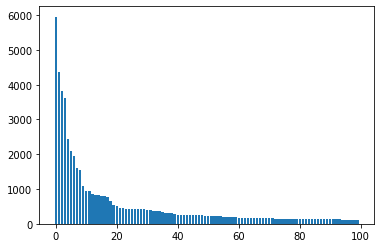

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

labels, values = zip(*counter.most_common(100))
plt.bar(range(len(labels)), values)
plt.show()

## Exploration 2: Information extraction

Load spaCy.

In [16]:
import spacy

Load the English language model.

In [17]:
nlp = spacy.load('en_core_web_sm')

Define a short text.

In [18]:
text = u'Apple Corp. buys Alphabet Inc. for $1 billion'

Process the text using the default pipeline.

In [20]:
doc = nlp(text)
doc

Apple Corp. buys Alphabet Inc. for $1 billion

Print the tokens together with their lemmas, part-of-speech tags, and stopword flags.

In [21]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.is_stop)

Apple Apple PROPN False
Corp. Corp. PROPN False
buys buy VERB False
Alphabet Alphabet PROPN False
Inc. Inc. PROPN False
for for ADP True
$ $ SYM False
1 1 NUM False
billion billion NUM False


Show the dependency parse.

In [22]:
from spacy import displacy

displacy.render(doc, style='dep', options={'distance': 110}, jupyter=True)

Show the named entities.

In [23]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

The following function will find the root word of an entity.

In [24]:
def root(ent):
    for token in ent:
        while not token.head is token and ent.start <= token.head.i and token.head.i < ent.end:
            token = token.head
        return token

Extract semantic relations.

In [25]:
for ent1 in doc.ents:
    root1 = root(ent1)
    for ent2 in doc.ents:
        root2 = root(ent2)
        if root1.head == root2.head and root1.head.pos_ == 'VERB' and root1.dep_ == 'nsubj' and root2.dep_ == 'dobj':
            print('[{}]-[{}]-[{}]'.format(ent1, root1.head.lemma_, ent2))

[Apple Corp.]-[buy]-[Alphabet Inc.]


## Exploration 3: Topic modelling

Import gensim.

In [ ]:
import gensim

Disable some warnings.

In [42]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

Build the vocabulary and show its size.

In [28]:
dictionary = gensim.corpora.Dictionary(tokens(text) for text in df['text'])
len(dictionary)

13241

Filter out stop words, as well as extremely frequent/infrequent words.

In [29]:
bad_ids = [i for t, i in dictionary.token2id.items() if nlp.vocab[t].is_stop]
dictionary.filter_tokens(bad_ids=bad_ids)
dictionary.filter_extremes()
len(dictionary)

2543

Create an iterator over the data (for efficiency).

In [30]:
class MyCorpus(object):
    def __iter__(self):
        for text in df['text']:
            yield dictionary.doc2bow(tokens(text))

Build the LDA model (takes a while).

In [43]:
lda = gensim.models.ldamodel.LdaModel(
    corpus=MyCorpus(),
    num_topics=8,
    id2word=dictionary,
    chunksize=5,
    passes=10,
    update_every=1,
    alpha='auto',
)

Print the most common topics.

In [44]:
lda.print_topics(8)

[(0,
  '0.049*"fun" + 0.035*"documentary" + 0.023*"good" + 0.023*"way" + 0.017*"real" + 0.016*"formula" + 0.016*"cinematic" + 0.016*"action" + 0.016*"fans" + 0.015*"great"'),
 (1,
  '0.096*"film" + 0.086*"movie" + 0.028*"funny" + 0.019*"dull" + 0.019*"little" + 0.012*"makes" + 0.012*"bland" + 0.011*"surprises" + 0.011*"nice" + 0.011*"long"'),
 (2,
  '0.029*"feels" + 0.019*"weird" + 0.018*"world" + 0.018*"movies" + 0.017*"hard" + 0.015*"picture" + 0.014*"major" + 0.013*"mystery" + 0.013*"moments" + 0.012*"love"'),
 (3,
  '0.041*"director" + 0.038*"story" + 0.031*"awful" + 0.030*"compelling" + 0.023*"opportunity" + 0.018*"predictable" + 0.018*"words" + 0.015*"tale" + 0.014*"screen" + 0.012*"despite"'),
 (4,
  '0.042*"characters" + 0.035*"seen" + 0.033*"fresh" + 0.025*"away" + 0.017*"fire" + 0.016*"come" + 0.015*"look" + 0.014*"depth" + 0.012*"things" + 0.012*"end"'),
 (5,
  '0.050*"bad" + 0.048*"thriller" + 0.034*"drama" + 0.029*"plot" + 0.022*"time" + 0.021*"script" + 0.017*"experience"

Load the pyLDAvis library for data visualization.

In [45]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

Visualize the LDA model.

In [46]:
pyLDAvis.gensim.prepare(lda, list(MyCorpus()), dictionary, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -108.958252 -208.941483       1        1  19.340566
5      186.487061  -98.103249       2        1  12.636086
0       19.245832  160.858780       3        1  12.551806
3      170.658829   75.445076       4        1  11.995516
6       -1.386411  -35.043739       5        1  11.492452
2     -145.800095  106.944611       6        1  10.972401
4       64.834541 -221.825272       7        1  10.827965
7     -196.906036  -58.990913       8        1  10.183207, topic_info=             Term        Freq       Total Category  logprob  loglift
102          film  735.000000  735.000000  Default  30.0000  30.0000
94          movie  657.000000  657.000000  Default  29.0000  29.0000
170        comedy  402.000000  402.000000  Default  28.0000  28.0000
51           like  314.000000  314.000000  Default  27.0000  27.0000
1404          bad  252.000000  252.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1197      genuine   26.273825   37.275222   Topic8  -5.0270   1.9347
2483   irritating   19.560347   57.039143   Topic8  -5.3221   1.2142
1078     terrible   20.805089  198.076154   Topic8  -5.2604   0.0310
1133  pretentious   18.393609  265.639088   Topic8  -5.3836  -0.3857
1695         lame   17.857726  182.421489   Topic8  -5.4132  -0.0395

[310 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1164      7  0.938645  absolutely
43        3  0.927496      acting
44        3  0.978187      action
83        1  0.962681      actors
486       7  0.962516    american
...     ...       ...         ...
281       5  0.046816       years
281       6  0.046816       years
281       7  0.031211       years
281       8  0.031211       years
112       1  0.975246       young

[428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 4, 7, 3, 5, 8])

That&rsquo;s all, folks!